In [59]:
import json
import re
from pathlib import Path
from ruamel.yaml import YAML

project_path = Path(r"C:\Users\Owner\Documents\repos\COMP4905\pose-estimation\MousePose-AndreTelfer-2020-05-21")

yaml = YAML()
with open(project_path / 'config.yaml', 'r') as fp:
    config = yaml.load(fp)

# What Frames are Already Labelled?

In [71]:
labeled_data_folder = project_path / "labeled-data"
labeled_frames = {}

r = re.compile("img(\d+).png")
for video_folder in os.listdir(labeled_data_folder):
    images = os.listdir(labeled_data_folder / video_folder)
    images = list(filter(lambda x: r.match(x), images))
    frames = list(map(lambda x: int(r.match(x).group(1)), images))
    
    labeled_frames[video_folder] = frames
    
print(json.dumps(labeled_frames, indent=4))

{
    "Rat 2 LPS 1": [
        0,
        1323,
        17072,
        19623,
        24044,
        41117,
        51152
    ],
    "Rat 4 Control 1": [
        0,
        6179,
        16331,
        23834,
        41489,
        42372,
        48110,
        52303
    ]
}


# Random Sample Frames

## Select Videos

### Get Videos from Project

In [44]:
import os
import shutil

# Temporarily change the CWD, this lets us use pathlib to resolve relative paths
initial_cwd = os.getcwd()
os.chdir(project_path)
    
videos = list(config['video_sets'].keys())
videos = list(map(lambda x: Path(os.path.abspath(x)), videos))

# Change CWD back
os.chdir(initial_cwd)

videos

[WindowsPath('C:/Users/Owner/Documents/repos/COMP4905/pose-estimation/MousePose-AndreTelfer-2020-05-21/videos/Rat 2 LPS 1.MP4'),
 WindowsPath('C:/Users/Owner/Documents/repos/COMP4905/pose-estimation/MousePose-AndreTelfer-2020-05-21/videos/Rat 4 Control 1.MP4')]

### Specify Videos Manually

In [46]:
video_folder = Path(r"C:\Users\Owner\Documents\repos\COMP4905\videos")
videos = [
    *map(lambda x: video_folder / x, os.listdir(video_folder))
]

# Sample Frames According to Spring Simulation

Rat 2 LPS 1:
	Frames: 63720
	Labeled: [0, 1323, 17072, 19623, 24044, 41117, 51152]
	New: [ 5364 46884 37306 19794   630 43888 51744 27153   600 35262 14859 38442
 36701 31114  3019 23736 42859 23414 53558 41101 48465 27306 24878 57718
 54371 33365 18115 13177 33770 33703 59933 47881 24006 53082  8488 29607
 62513 15457 22285 13623 25964 18553 43063 53420 14303 13990 17515 45310
 45164 52245 10438 60686 61816  8899   522 32798 30369 39879 32085 62221
  3209 48236 29463 26135 26175 42829 57703 12670 53018  3727 55768 62373
 43977 28421  2430 22904 54160 21920 43096 28021 46430 56680 36501 13235
  9631 29146 26376  5978 55721 36459 62266  4894  8565 53465 16320 11766
   519 50331 53663 51135]


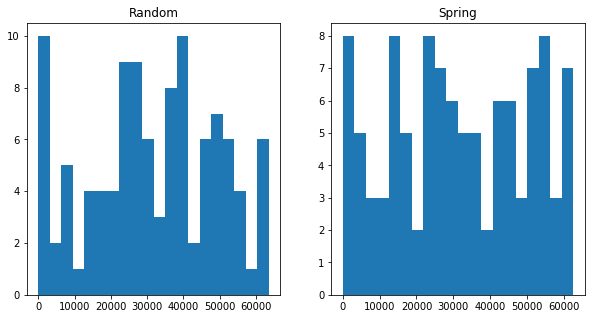

In [347]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

n_samples = 100
def spring(frames, n_samples, fixed_points, k=1e3, dt=1, n=10000, x=None):
     # Spring simulation
    v = np.zeros(n_samples)
    
    if x is not None:
        x = x.copy()
    else:
        x = np.random.choice(np.arange(frames+1), size=n_samples).astype(np.float32)
    
    for _ in range(n):
        points = np.array(fixed_points + list(x))
        p1, p2 = np.meshgrid(x, points) # Create a mesh of points p1 and p2
        delta = p1-p2
        delta[delta==0] = 1e10
        f = np.sum(k / delta**2 * np.sign(delta), axis=0) # force
        v += f * dt
        x += v * dt
        
        # Wrap around points that overshoot
        x %= frames
        
    x = x.astype(int)
    x[x>frames] = frames
    x[x<0] = 0
    return x

for video in videos:
    cap = cv2.VideoCapture(str(video))
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    name, ext = os.path.splitext(video.name)
    fixed_points = labeled_frames[name]
    
    x0 = np.random.choice(np.arange(frames+1), size=n_samples).astype(np.float32)
    x = spring(frames, n_samples, fixed_points, x=x0)
    print(f"{name}:")
    print(f"\tFrames: {frames}")
    print(f"\tLabeled: {fixed_points}")
    print(f"\tNew: {x}")
    break
    
bins = 20
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
pts = list(fixed_points) + list(x0)
plt.hist(pts, bins=bins)
# xx, yy = np.meshgrid(pts, pts)
# deltas_squared = np.sum(np.sort(np.abs(xx-yy), axis=0)[:,:5])
metric = scipy.stats.entropy(pts)
plt.title(f"Random")

plt.subplot(1, 2, 2)
pts = list(fixed_points) + list(x)
plt.hist(pts, bins=bins)
# xx, yy = np.meshgrid(pts, pts)
# metric = np.sum(np.sort(np.abs(xx-yy), axis=0)[:,:5])
# metric = scipy.stats.entropy(pts)
plt.title(f"Spring")

plt.savefig("spring-test.png")